In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
import os

In [5]:
%store -r df_Xy

In [6]:
df_Xy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3032 entries, 2008-09-05 to 2020-05-27
Columns: 363 entries, gbp_rate to gold_dif_lag10
dtypes: float64(363)
memory usage: 8.4 MB


# We want to investigate the predictivty of central bank policy rates and stock market index performance as they relate to the price of gold. 
## The core question here is if the addition of central bank rates and stock market indices to a model can outperform a model that only uses gold's price and an up to a 10 period lag as a features.

## We'll attempt to use time series modeling to predict the daily price, daily price difference, and daily percent change in price of gold.
### We have the most recent 10 years of daily data from the following sources:
### Features:
#### Top 5 equity market indices by market capitalization, per Statista: https://www.statista.com/statistics/270126/largest-stock-exchange-operators-by-market-capitalization-of-listed-companies/, and their corresponding daily performance and percent change
NYSE Composite Index history: https://finance.yahoo.com/quote/%5ENYA?p=^NYA&.tsrc=fin-srch
NASDAQ Composite Index history: https://finance.yahoo.com/quote/%5EIXIC?p=^IXIC&.tsrc=fin-srch
Japan Exchange Group Composite Index history: https://finance.yahoo.com/quote/8697.T?p=8697.T&.tsrc=fin-srch
Shanghai Stock Exchange Composite Index history: https://finance.yahoo.com/quote/%5ESSEC?p=^SSEC&.tsrc=fin-srch
Hang Seng (Hong Kong) Index History: https://finance.yahoo.com/quote/%5EHSI?p=^HSI&.tsrc=fin-srch
#### Top 5 Currencies Globally in Forex Trading (https://www.ig.com/us/trading-strategies/top-10-most-traded-currency-pairs-191206), and their corresponding daily central bank policy rates and percent change
The Fed (USD): https://fred.stlouisfed.org/series/FEDFUNDS
ECB (EUR): https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html
BoJ (JPY): https://fred.stlouisfed.org/series/IRSTCI01JPM156N
United Kingdom (GBP): https://fred.stlouisfed.org/series/GBPONTD156N
Australia (AUD): https://www.rba.gov.au/statistics/cash-rate/
#### Daily price of gold  and percent change (up to 10-day lag): https://www.usagold.com/reference/prices/goldhistory.php

### Targets:
#### Daily price of gold, daily difference in gold price, daily percent change price of gold: https://www.usagold.com/reference/prices/goldhistory.php

## As the data sits, we currently have both daily policy rates and index scores (along with differences and percent changes) - each with up to a ten day lag on the data. This translates to  121 features each in our 3 would-be models (daily price, daily price difference, daily percent price change).

### Let's start by separating our data

In [7]:
# store column titles to create separate dataframes for raw values, differences, and percent changes

col_raw = []
col_dif = []
col_change = []

for col in df_Xy.columns:
    if 'change%' in col:
        col_change.append(col)
    elif 'dif' in col:
        col_dif.append(col)
    else:
        col_raw.append(col)

In [8]:
# create three separate dataframes, one with raw values, one with differences, and one with percent change

df_Xy_raw = df_Xy[col_raw].dropna()

df_Xy_dif = df_Xy[col_dif].dropna()

df_Xy_change = df_Xy[col_change].dropna()

In [9]:
df_Xy_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3022 entries, 2008-09-19 to 2020-05-27
Columns: 121 entries, gbp_rate to gold_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [10]:
df_Xy_dif.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate_dif to gold_dif_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [11]:
df_Xy_dif.reset_index(inplace = True)

In [12]:
df_Xy_change.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3032 entries, 2008-09-05 to 2020-05-27
Columns: 121 entries, gbp_rate_change% to gold_change%_lag10
dtypes: float64(121)
memory usage: 2.8 MB


#### To compare models on a level playing field, we need to ensure the same date range is being used for both the raw and the change data. Let's take a look at the date ranges in all of our datasets. It looks like our difference dataframe is the limiting factor here with '2008-09-22' being the earliest date in the dataset.

In [13]:
df_Xy_raw = df_Xy_raw[df_Xy_raw.index >= '2008-09-22']
df_Xy_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate to gold_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [14]:
df_Xy_raw.reset_index(inplace = True)

In [15]:
df_Xy_change = df_Xy_change[df_Xy_change.index >= '2008-09-22']
df_Xy_change.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate_change% to gold_change%_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [16]:
df_Xy_change.reset_index(inplace = True)

In [17]:
# create X,y pairs for both raw and percent change dataframes

X_raw = df_Xy_raw.drop(columns = ['gold'])
y_raw = df_Xy_raw['gold']

X_dif = df_Xy_dif.drop(columns = ['gold_dif'])
y_dif = df_Xy_dif['gold_dif']

X_change = df_Xy_change.drop(columns = ['gold_change%'])
y_change = df_Xy_change['gold_change%']

## EDA
### Historical Gold Data Trends and Moving Averages

In [18]:
# We default the window here to 365 as we have daily data, and we want to average-out seasonal patterns, if they exist
def fit_moving_average_trend(series, window=365):
    return series.rolling(window, center=True).mean()

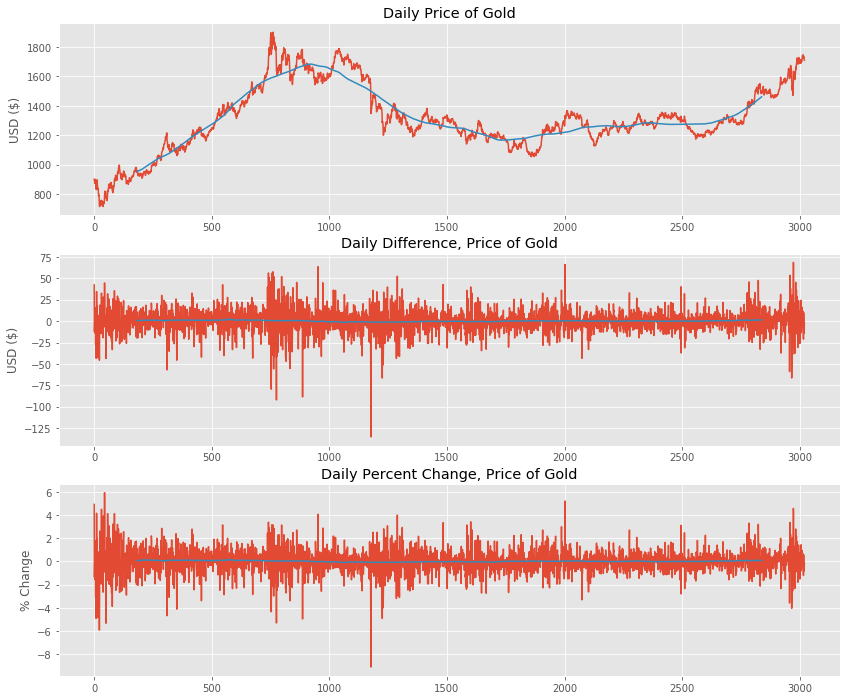

In [19]:
fig,axs = plt.subplots(3,1, figsize = (14,12))

for ax,metric,series in zip(axs,[('Daily Price of Gold','USD ($)'), ('Daily Difference, Price of Gold','USD ($)'),\
                            ('Daily Percent Change, Price of Gold','% Change')],[y_raw,y_dif,y_change]):
        
        ma = fit_moving_average_trend(series)
        ax.plot(series.index,series)
        ax.plot(series.index,ma, label = 'Moving Average')
        ax.set_title(metric[0])
        ax.set_ylabel(metric[1])
        ax.grid(b=True, which = 'minor', axis = 'both')
# plt.tight_layout()        

## EDA
### Testing for Stationarity with Augmented Dickey Fuller

In [20]:
for title, series in zip(['Daily Price of Gold', 'Daily Difference, Price of Gold','Daily Percent Change, Price of Gold'],[y_raw,y_dif,y_change]):
    test = sm.tsa.stattools.adfuller(series)
    print(f'{title} ADF p-value: {round(test[1],3)}')

Daily Price of Gold ADF p-value: 0.397
Daily Difference, Price of Gold ADF p-value: 0.0
Daily Percent Change, Price of Gold ADF p-value: 0.0


So we now know that both gold's Daily Price Difference and Daily Percent Change are stationary.
Let's take a look at some autocorrelation and partial autocorrelation plots to see if an AR (auto-regressive) model  would make sense for our baselines

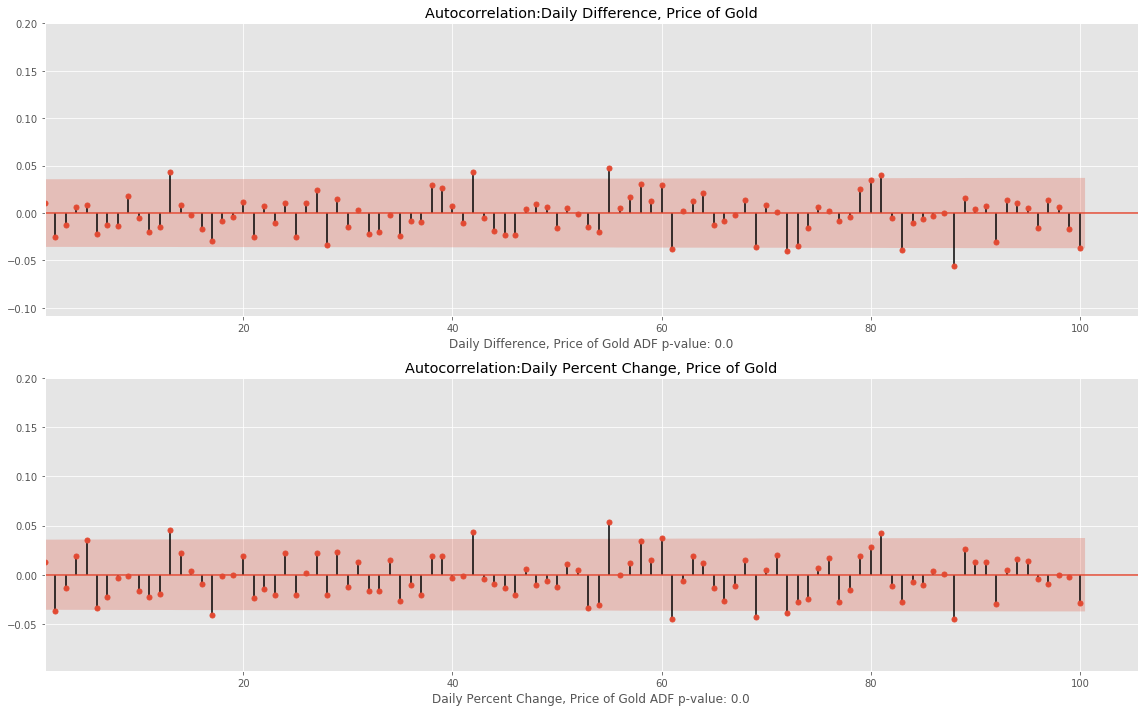

In [21]:
fig, axs = plt.subplots(2, figsize=(16, 10))

for ax, title, series in zip(axs, ['Daily Difference, Price of Gold','Daily Percent Change, Price of Gold'],[y_dif,y_change]):
    test = sm.tsa.stattools.adfuller(series)
    
    sm.graphics.tsa.plot_acf(series, lags=100, ax=ax)
    ax.set_title(f'Autocorrelation:{title}')
    
    # The zeroth value in these graphs is pointless (a dataset is perfectly correlated to itself)
    ax.set_xlim(left = 1)
    ax.set_ylim(top = 0.2)
    ax.set_xlabel(f'{title} ADF p-value: {round(test[1],3)}')

plt.tight_layout()

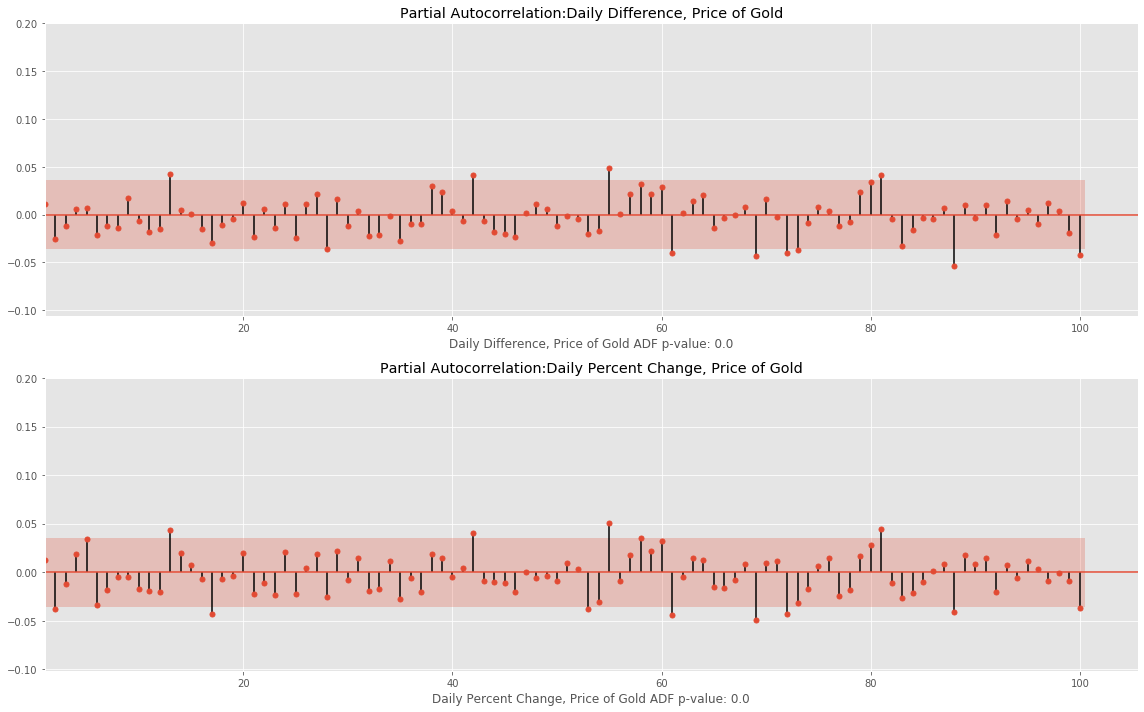

In [22]:
fig, axs = plt.subplots(2, figsize=(16, 10))

for ax, title, series in zip(axs, ['Daily Difference, Price of Gold','Daily Percent Change, Price of Gold'],[y_dif,y_change]):
    test = sm.tsa.stattools.adfuller(series)
    
    sm.graphics.tsa.plot_pacf(series, lags=100, ax=ax)
    ax.set_title(f'Partial Autocorrelation:{title}')
    
    # The zeroth value in these graphs is pointless (a dataset is perfectly correlated to itself)
    ax.set_xlim(left = 1)
    ax.set_ylim(top = 0.2)
    ax.set_xlabel(f'{title} ADF p-value: {round(test[1],3)}')

plt.tight_layout()

### While we've proven stationarity in daily price difference and daily percent change, our Autocorrelation plots leave a lot to be desired. An AR based model doesn't seem like the proper approach, but linear regression actually assumes an absence of autocorrelation. To get the simplest of baselines, let's fit a linear model with gold's price difference and price change with the features being a 1 through 10 day lag.

#### Linear Model Assumptions:
- Linear relationship - check with scatters and pearsonr tests
- Errors are normally distributed
- Homoscedasticity of errors (or, equal variance around the line) - fit a model and visualize
- Independence of the observations - We may be breaking the rules a bit here. We're realing most concerned with generating a baseline model. 

In [23]:
# generate gold difference and gold % change dfs with lag

#Difference
col_gold_dif = []
for col in X_dif.columns:
    if 'gold' in col:
        col_gold_dif.append(col)

X_dif_gold = X_dif[col_gold_dif]
X_dif_gold.info()
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gold_dif_lag1   3021 non-null   float64
 1   gold_dif_lag2   3021 non-null   float64
 2   gold_dif_lag3   3021 non-null   float64
 3   gold_dif_lag4   3021 non-null   float64
 4   gold_dif_lag5   3021 non-null   float64
 5   gold_dif_lag6   3021 non-null   float64
 6   gold_dif_lag7   3021 non-null   float64
 7   gold_dif_lag8   3021 non-null   float64
 8   gold_dif_lag9   3021 non-null   float64
 9   gold_dif_lag10  3021 non-null   float64
dtypes: float64(10)
memory usage: 236.1 KB


In [24]:
#Percent Change
col_gold_change = []
for col in X_change.columns:
    if 'gold' in col:
        col_gold_change.append(col)

X_change_gold = X_change[col_gold_change]
X_change_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gold_change%_lag1   3021 non-null   float64
 1   gold_change%_lag2   3021 non-null   float64
 2   gold_change%_lag3   3021 non-null   float64
 3   gold_change%_lag4   3021 non-null   float64
 4   gold_change%_lag5   3021 non-null   float64
 5   gold_change%_lag6   3021 non-null   float64
 6   gold_change%_lag7   3021 non-null   float64
 7   gold_change%_lag8   3021 non-null   float64
 8   gold_change%_lag9   3021 non-null   float64
 9   gold_change%_lag10  3021 non-null   float64
dtypes: float64(10)
memory usage: 236.1 KB


### Linear Regression Model: Daily Gold Price Differece, 10 day lag

In [25]:
from sklearn.linear_model import LinearRegression

Because we're using time series based data, our train-test split will need to ensure that our data stays chronological.

In [26]:
from sklearn.model_selection import TimeSeriesSplit

In [27]:
tscv = TimeSeriesSplit()

In [28]:
train_X_dif_gold = X_dif_gold[:int(X_dif_gold.shape[0]*0.7)]
test_X_dif_gold = X_dif_gold[int(X_dif_gold.shape[0]*0.7):]
train_y_dif = y_dif[:int(X_dif_gold.shape[0]*0.7)]
test_y_dif = y_dif[int(X_dif_gold.shape[0]*0.7):]

#### Cross Validation: Linear Regression of Daily Price Difference, 10 day lag

In [33]:
def cross_val_and_score(X_train, X_test, y_train, y_test):
    
    
    """
    PARAMETERS:
    X_train - Training feature dataset in pandas DataFrame
    X_test - Test feature dataset in pandas DataFrame
    y_train - Training target dataset in pandas DataFrame
    y_test - Test target dataset in pandas DataFrame
    
    RETURNS:
    numpy array of cross_validation and final train/test score
    
    """
    
    
    r2_score = []
    for tr_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train.loc[tr_index], X_train.loc[val_index]
        y_tr, y_val = y_train.loc[tr_index], y_train.loc[val_index]
        
        m_dif = LinearRegression()
    
        m_dif.fit(X_tr,y_tr)
    
        r2_score.append(m_dif.score(X_val,y_val))
        print(f'Model R2 Score:{m_dif.score(X_val,y_val)}')
    
    m_dif = LinearRegression()
    m_dif.fit(X_train,y_train)
    r2_score.append(m_dif.score(X_test,y_test))
    print(f'Final Model R2 Score:{m_dif.score(X_test,y_test)}')
    return r2_score

In [34]:
cross_val_and_score(train_X_dif_gold, test_X_dif_gold, train_y_dif, test_y_dif)

Model R2 Score:-0.05549211956541056
Model R2 Score:-0.01108450515151227
Model R2 Score:-0.02562804377328831
Model R2 Score:-0.032908153644443994
Model R2 Score:-0.016146244487514894
Final Model R2 Score:-0.014188181637116326


[-0.05549211956541056,
 -0.01108450515151227,
 -0.02562804377328831,
 -0.032908153644443994,
 -0.016146244487514894,
 -0.014188181637116326]

### Linear Regression Model: Daily Gold Price Percent Change, 10 day lag

In [35]:
tscv = TimeSeriesSplit()
train_X_change_gold = X_change_gold[:int(X_change_gold.shape[0]*0.7)]
test_X_change_gold = X_change_gold[int(X_change_gold.shape[0]*0.7):]
train_y_change = y_change[:int(X_change_gold.shape[0]*0.7)]
test_y_change = y_change[int(X_change_gold.shape[0]*0.7):]

#### Cross Validation: Linear Regression of Daily Gold Price Percent Change, 10 day lag

In [36]:
cross_val_and_score(train_X_change_gold, test_X_change_gold, train_y_change, test_y_change)

Model R2 Score:-0.06513826848471238
Model R2 Score:-0.022453326910640836
Model R2 Score:-0.02170252873921119
Model R2 Score:-0.03610113552682592
Model R2 Score:-0.010943800137119597
Final Model R2 Score:-0.018676240351757523


[-0.06513826848471238,
 -0.022453326910640836,
 -0.02170252873921119,
 -0.03610113552682592,
 -0.010943800137119597,
 -0.018676240351757523]